In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import random

import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

In [11]:
learning_rate = 0.001
batch_size = 10
epochs = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [5]:
train_path = 'C:/Users/sgold/laba5/train'
test_path = 'C:/Users/sgold/laba5/test'
val_path = 'C:/Users/sgold/laba5/val'
path_to_dataset=r"C:/Users/sgold/laba5/dataset/"

df = pd.read_csv(os.path.join(path_to_dataset, "C:/Users/sgold/laba5/dataset_csv.csv"), header=None, delimiter=";", names=['path_to_image', 'label'])
if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def train_loading(df, path, i):
    image_path = df.path_to_image[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.label[i]}.{i}.jpg'), image)

def test_loading(df, path, i):
    image_path = df.path_to_image[i]
    image = cv2.imread(image_path)
    if i - 880 > 109: 
        i = i - 1870
    else:
        i = i - 880
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

for i in range(880):
    train_loading(df, train_path, i)

for i in range(880, 990):
    train_loading(df, test_path, i)

for i in range(990, 1100):
    train_loading(df, val_path, i)

for i in range(1100, 1980):
    train_loading(df, train_path, i)

for i in range(1980, 2090):
    train_loading(df, test_path, i)

for i in range(2090, 2200):
    train_loading(df, val_path, i)
    

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))
train_list, val_list = train_test_split(train_list, test_size=0.1)
    

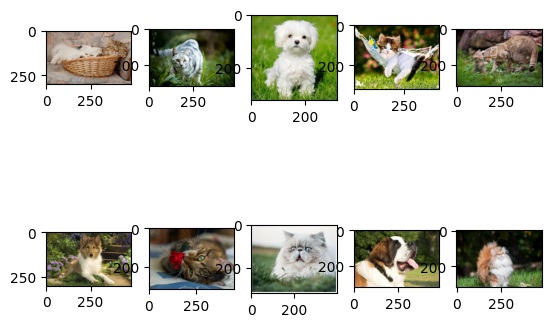

In [12]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = ConvNet().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [15]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)